# 2. Calculating a new variable from existing variables in the ROOT file

In this example, we calculate the $\Delta M = m(D^*) - m(D^0)$ variable in the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ Monte Carlo sample. In the $D^* \to D^0 \pi$ decay, there is very little phase space left over for the pion produced in the decay, because the mass difference between the $D^*$ and $D^0$ is only slightly more than the pion mass. Thus, we should see a strong peak in the $\Delta M$ distribution, which helps us to select $D^*$'s. 

Note for myself:  
$m(D^0) = 1,870$ MeV  
$m(D^{*\pm})= 2,010$ MeV  
$m(\pi^\pm) = 140$ MeV 
And

$D^{∗\pm}→D^0 π^\pm$  67.7 %  
($D^{∗\pm}→D^\pm π^0$  30.7 % and together: almost all the decays (98.4 %))

Some imports of stuff we need:

In [1]:
from root_pandas import read_root
import matplotlib.pyplot as plt
from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets
import numpy as np

#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.22/02


Now we load the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ Monte Carlo sample, which is a pure sample of simulated decays:

In [2]:
file_list = []
for y in years:
    for m in magnets:
        file_list.append(f"{loc.MC}/Bd_Dst3pi_11266018_{y}_{m}_Sim09e-ReDecay01.root")
tree_name = "DecayTree"
vars = ["D0_M","Dst_M"]
df = read_root(file_list, tree_name, columns=vars)

We can check how many MC events we have in our DataFrame:

In [3]:
n_events = len(df)
n_events

23692

Let's calculate the $\Delta M$ variable. In `pandas` this is super-simple - no loops like in traditional `ROOT`, no need for `SetBranchAddress` or declaring new branches! We simply define a new column in our DataFrame:

In [4]:
df["Delta_M"] = df["Dst_M"] - df["D0_M"]

We can check some properties of our new variable like it's mean:

In [5]:
mu = df["Delta_M"].mean()
print(f"Delta_M mu = {mu:.2f}")

Delta_M mu = 145.46


$$\Delta M = 2,010-1,870= 150 MeV$$
$$m(\pi^\pm) = 140\ MeV$$

**Follow-up tasks**

- At an earlier stage, our files have had a $143 < \Delta M < 148$ MeV cut applied to them. Can you plot the `Delta_M` variable we just calculated to check this?
- How does the $\Delta M$ compare in data and MC?
- Can you make a ratio of the data and MC distributions, to check how consistent they are? Try to make a `numpy` histgoram for each one, and then you can divide them.

## At an earlier stage, our files have had a 143<Δ𝑀<148 MeV cut applied to them. Can you plot the Delta_M variable we just calculated to check this?

I adapt the code plot_hist I used in the notebook 1.\
No particle or variable anymore but:
* variable (here, "Delta_M")
* name_variable ("$\Delta M$")
* unit_variable ("MeV/$c^2$")

In [14]:
def list_into_string(L, sep = '_'):
    string = ""
    for l in L:
        string += str(l)
        string += sep
    return string[:-len(sep)]

def plot_hist(dfs, variable, name_variable, unit_variable, n_bins = 100, mode_hist = False):
    """
    Plot the histogram of particle_variable, with number of bins = 100
    
    If df is a dictionnary:
    dfs={name_data:panda_dataframe,...}
    --> Plot several histograms in the same plot
    
    if mode_hist is on, I use histograms with density = True/False
    
    """
    
    density = len(dfs)>1 # if there are more than 2 histograms
    
    fig, ax = plt.subplots(figsize=(8,6))
    name_datas = list(dfs.keys())
        
    # Some features of the variable/particle
#     units_var = variables[variable]['unit']
#     name_var = variables[variable]['name']
    #name_particle = particle_names[particle]
    
    
    # Compute the number of bins
    #bin_width = 4
    
    #First loop to determine the low and high value
    low = np.inf
    high = -np.inf
    for name_data, df in dfs.items():
        low = min(low,df[variable].min())
        high = max(high,df[variable].max())
    bin_width = (high-low)/n_bins
    
    colors = ['r','b','g','k']
    k_col = 0
    
    labels = []
    for name_data, df in dfs.items():
        n_candidates = len(df[variable])
        label= f"{name_data}: {n_candidates} candidates" if density else None
        if mode_hist:
            alpha = 0.5 if density else 1            
            counts,_,_ = plt.hist(df[variable], range = [low,high],bins = n_bins, alpha = alpha,
                                  label = label, density = density)
            
        else:
            #Make the histogram, and get the bin centres and error on the counts in each bin
            counts, bin_edges = np.histogram(df[variable], n_bins, range=(low,high))
            bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
            #Plot the bin centres and counts in each bin
            err = np.sqrt(counts)
            if density:
                counts = counts/(n_candidates*bin_width)
                err = err/(n_candidates*bin_width)
            plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color=colors[k_col], label = label)
        k_col += 1
              
    #Some plot style stuff
    #Set the x title
    plt.xlabel("%s [%s]" %(name_variable,unit_variable),fontsize=30)
    
    #Set the y-title, which is number of candidates per bin
    ylabel = "Proportion of candidates" if density else "Candidates"
    fontsize = 25 if density else 30
    plt.ylabel(f"{ylabel} / ({bin_width:.1g} {unit_variable})", fontsize=fontsize)

    #Set lower and upper range of the x-axis
    plt.xlim(low,high)
    
    #Get the default y-limits, then redefine the plot to start at 0 and give it a bit more space on top (with the 1.1x)
    ymin, ymax = plt.ylim()
    plt.ylim(0.,ymax*1.2)

    #Set the font size of the axis numbers
    ax.tick_params(axis='both', which='major', labelsize=25)

    #Legend
    if density:
        plt.legend(fontsize = 20)
    
    #Remove any space not needed around the plot
    plt.tight_layout()

    plt.show()

    #Save the plot as a PDF document into our PLOTS folder (output/plots as defined in bd2dst3pi/locations.py)
    fig.savefig(f"{loc.PLOTS}/{variable}_{list_into_string(name_datas)}.pdf")

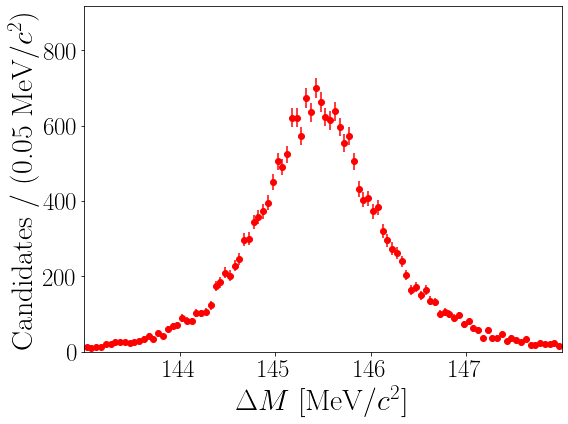

In [15]:
plot_hist({'MC':df},"Delta_M","$\Delta M$","MeV/$c^2$")

The 143<Δ𝑀<148 MeV cut has been visibly applied.

## Task 2 - How does the Δ𝑀 compare in data and MC?

Good question that I'm glad to answer. I've already everything the function to answer it :)
I just need to past the function to load the data

In [16]:
def load_data(years,magnets,vars,type_data = 'data'):
    """
    type_data = 'MC' or 'data'
    """
    if type_data == 'MC':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09c-ReDecay01.root'
    elif type_data == 'data':
        path = f"{loc.DATA}/data_90000000"
        ext = '.root'
    elif type_data == 'MCc':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09c-ReDecay01.root'
    elif type_data == 'MCe':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09e-ReDecay01.root'
    else:
        print('Choose your side')
    
    file_list = []
    for y in years:
        for m in magnets:
            file_list.append(f"{path}_{y}_{m}{ext}")
    tree_name = "DecayTree"
    df = read_root(file_list, tree_name, columns=vars)
    return df

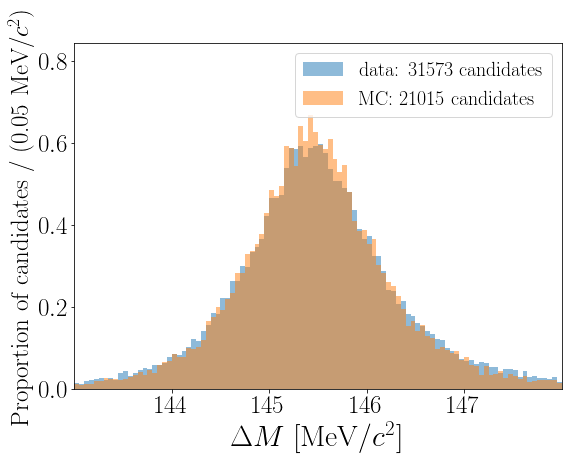

In [17]:
dfs = {
    'data':load_data(years,magnets,vars,type_data = 'data'),
    'MC':load_data(years,magnets,vars,type_data = 'MC')
}

for data_type, df in dfs.items():
    df["Delta_M"] = df["Dst_M"] - df["D0_M"] 

plot_hist(dfs, "Delta_M", "$\Delta M$","MeV/$c^2$", n_bins = 100, mode_hist = True)

The MC and data distribution are very close to each other!

## Task 3 - Can you make a ratio of the data and MC distributions, to check how consistent they are? Try to make a numpy histogram for each one, and then you can divide them.

Even if we do observe that the two distributions are close to each other, we want to compute their ratio in order to have a better idea of how consistent they are.

$$\frac{N_d\times N_{MC,tot}}{N_{MC}\times N_{d,tot}} \pm \frac{N_d\times N_{MC,tot}}{N_{MC}\times N_{d,tot}}\times \sqrt{\left(\frac{\Delta N_d}{N_d}\right)^2+\left(\frac{\Delta N_{MC}}{N_{MC}}\right)^2}$$


In [18]:
def plot_divide(dfs, variable, name_variable,unit_variable, n_bins = 100):
    """
    dfs={name_data1:df1,name_data2:df2}
    plot the (histogram name_data1)/(histogram of namedata2) AFTER NORMALISATION ofc.
        
    """
       
    fig, ax = plt.subplots(figsize=(8,6))
    name_datas = list(dfs.keys())
    
    # Compute the number of bins
    #bin_width = 4
    
    #First loop to determine the low and high value
    low = np.inf
    high = -np.inf
    for name_data, df in dfs.items():
        low = min(low,df[variable].min())
        high = max(high,df[variable].max())
    bin_width = (high-low)/n_bins
    
    colors = ['r','b','g','k']
    k_col = 0
    
    labels = []
    #Make the histogram, and get the bin centres and error on the counts in each bin
    list_dfs = list(dfs.values())
    list_type_data = list(dfs.keys())
    counts1, bin_edges = np.histogram(list_dfs[0][variable], n_bins, range=(low,high))
    counts2, _ = np.histogram(list_dfs[1][variable], n_bins, range=(low,high))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    err1 = np.sqrt(counts1)
    err2 = np.sqrt(counts2)
    
    #division
    
    division = counts1*counts2.sum()/(counts2*counts1.sum()) 
    err = division*np.sqrt((err1/counts1)**2+(err2/counts2)**2)

    plt.errorbar(bin_centres, division, yerr=err, fmt='o', color='k')
    plt.plot([low,high], [1.,1.], linestyle='--', color='b',marker='')
    #Some plot style stuff
    #Set the x title
    plt.xlabel("%s[%s]" %(name_variable,unit_variable),fontsize=30)
    
    #Set the y-title, which is number of candidates per bin
    plt.ylabel("candidates[%s] / candidates[%s] \n / (%.1g {%s})"%(list_type_data[0],
                                                                   list_type_data[1],
                                                                   bin_width,
                                                                   unit_variable), 
               fontsize=30)

    #Set lower and upper range of the x-axis
    plt.xlim(low,high)
    
    #Get the default y-limits, then redefine the plot to start at 0 and give it a bit more space on top (with the 1.1x)
    ymin, ymax = plt.ylim()
    plt.ylim(0.,ymax*1.2)

    #Set the font size of the axis numbers
    ax.tick_params(axis='both', which='major', labelsize=25)

    
    #Remove any space not needed around the plot
    plt.tight_layout()

    plt.show()

    #Save the plot as a PDF document into our PLOTS folder (output/plots as defined in bd2dst3pi/locations.py)
    fig.savefig(f"{loc.PLOTS}/{variable}_{list_into_string(name_datas,'_d_')}.pdf")

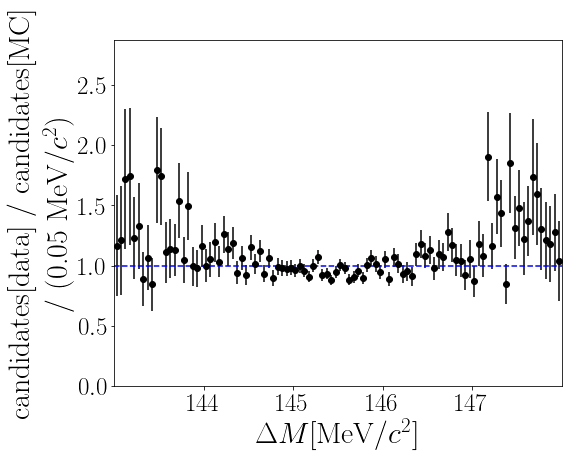

In [19]:
plot_divide(dfs, "Delta_M", "$\Delta M$","MeV/$c^2$")

The are some discrepancies.